In [ ]:
!pip install timm torch torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# ✅ Step 1: Imports
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm



In [ ]:
#link for dataset https://drive.google.com/drive/folders/1xcEjPJBxz10Dd6yql_MblZe_jjz3tvEC?usp=sharing

In [ ]:
# ✅ Step 2: Set paths & transforms
data_dir = "/content/drive/MyDrive/real_and_fake_facedataset"  # must have 'real' and 'fake' folders

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])





In [ ]:
# ✅ Step 3: Load Dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply val/test transform to val and test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class mappings
print("Class to Index Mapping:", full_dataset.class_to_idx)



Class to Index Mapping: {'Fake': 0, 'Real': 1}


In [ ]:
# ✅ Step 4: Compute Class Weights
all_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)


Class Weights: tensor([1.0938, 0.9211])


In [ ]:
# ✅ Step 5: Model, Loss, Optimizer
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=2e-5)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# ✅ Step 6: Training Loop
epochs = 10


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")





Epoch 1/10: 100%|██████████| 45/45 [01:01<00:00,  1.37s/it, loss=0.645]


Epoch 1 Loss: 0.6901


Epoch 2/10: 100%|██████████| 45/45 [01:02<00:00,  1.38s/it, loss=0.237]


Epoch 2 Loss: 0.4049


Epoch 3/10: 100%|██████████| 45/45 [01:02<00:00,  1.39s/it, loss=0.0854]


Epoch 3 Loss: 0.1480


Epoch 4/10: 100%|██████████| 45/45 [01:03<00:00,  1.41s/it, loss=0.0598]


Epoch 4 Loss: 0.0632


Epoch 5/10: 100%|██████████| 45/45 [01:03<00:00,  1.42s/it, loss=0.0241]


Epoch 5 Loss: 0.0451


Epoch 6/10: 100%|██████████| 45/45 [01:03<00:00,  1.41s/it, loss=0.000771]


Epoch 6 Loss: 0.0130


Epoch 7/10: 100%|██████████| 45/45 [01:03<00:00,  1.41s/it, loss=0.181]


Epoch 7 Loss: 0.0132


Epoch 8/10: 100%|██████████| 45/45 [01:05<00:00,  1.46s/it, loss=0.124]


Epoch 8 Loss: 0.0955


Epoch 9/10: 100%|██████████| 45/45 [01:04<00:00,  1.42s/it, loss=0.016]


Epoch 9 Loss: 0.0348


Epoch 10/10: 100%|██████████| 45/45 [01:03<00:00,  1.41s/it, loss=0.000426]

Epoch 10 Loss: 0.0035


Classification Report:
               precision    recall  f1-score   support

        Fake       0.86      0.73      0.79       172
        Real       0.71      0.84      0.77       135

    accuracy                           0.78       307
   macro avg       0.78      0.79      0.78       307
weighted avg       0.79      0.78      0.78       307



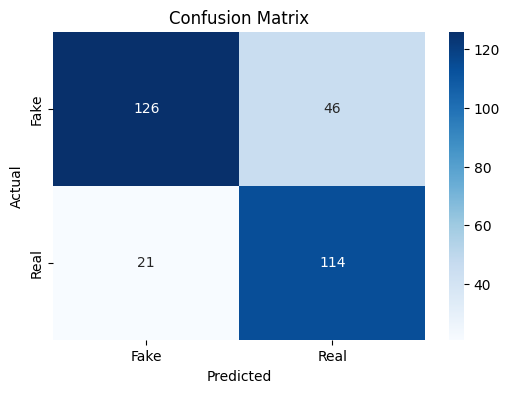

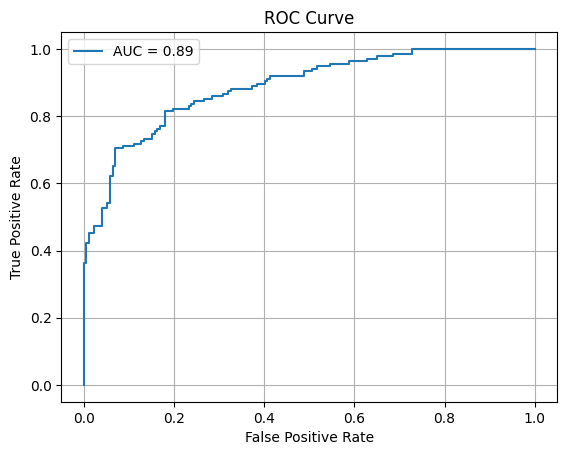

In [ ]:
# ✅ Step 7: Evaluation

import matplotlib.pyplot as plt
import seaborn as sns
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities for class 1 (real)

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()




In [ ]:
torch.save(model.state_dict(), "deepfake_vit_model.pth")
print("Model saved as deepfake_vit_model.pth")


Model saved as deepfake_vit_model.pth
